In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [4]:
# Figure S3
tracker = joblib.load('Results/tracker_MeanActivations.pkl')
tracker_info = joblib.load('Results/tracker_LayerInfo.pkl')

trainings = 10
sns.set_context('poster')
layers_i = [3, 5, 7, 9, 11, 13, 15, 18]

gains = tracker['gains']
num_rands_all = [1.125, 1.25, 1.5,2, 3, 4, 5,6, 8, 10, 20, 30, 40]
num_rands_all = list(reversed(num_rands_all))
colors = sns.color_palette('magma_r', len(num_rands_all))
color_idx = [0, 1, 2, 3, 4, 5, 7, -3]
colors_select= [colors[c] for c in color_idx]

num_rands = [1.125, 1.25, 1.5, 2, 3, 4, 6,  20]

df = pd.DataFrame({'Layer':[],
                   'Block':[],
                   'Num_rand':[],
                   'Gain':[],
                   'Training':[],
                   'Activation':[],
                   'Decoding accuracy':[]})
c = 0
for p,l in enumerate(layers_i):
    for n, num_rand in enumerate(num_rands):
        tag = 'random' + str(num_rand)
        for t in range(trainings):
            for i, g in enumerate(tracker['gains']):
                df.loc[c, 'Layer'] = l
                df.loc[c, 'Block'] = p + 1
                df.loc[c, 'Gain'] = g
                df.loc[c, 'Num_rand'] = num_rand
                df.loc[c, 'Training'] = t
                df.loc[c, 'Activation'] = tracker['random' + str(num_rand)]['training_' + str(t)]['means'][p][i]
                df.loc[c, 'Decoding accuracy'] = tracker_info[tag]['training_' + str(t)][l][i]
                c = c+1


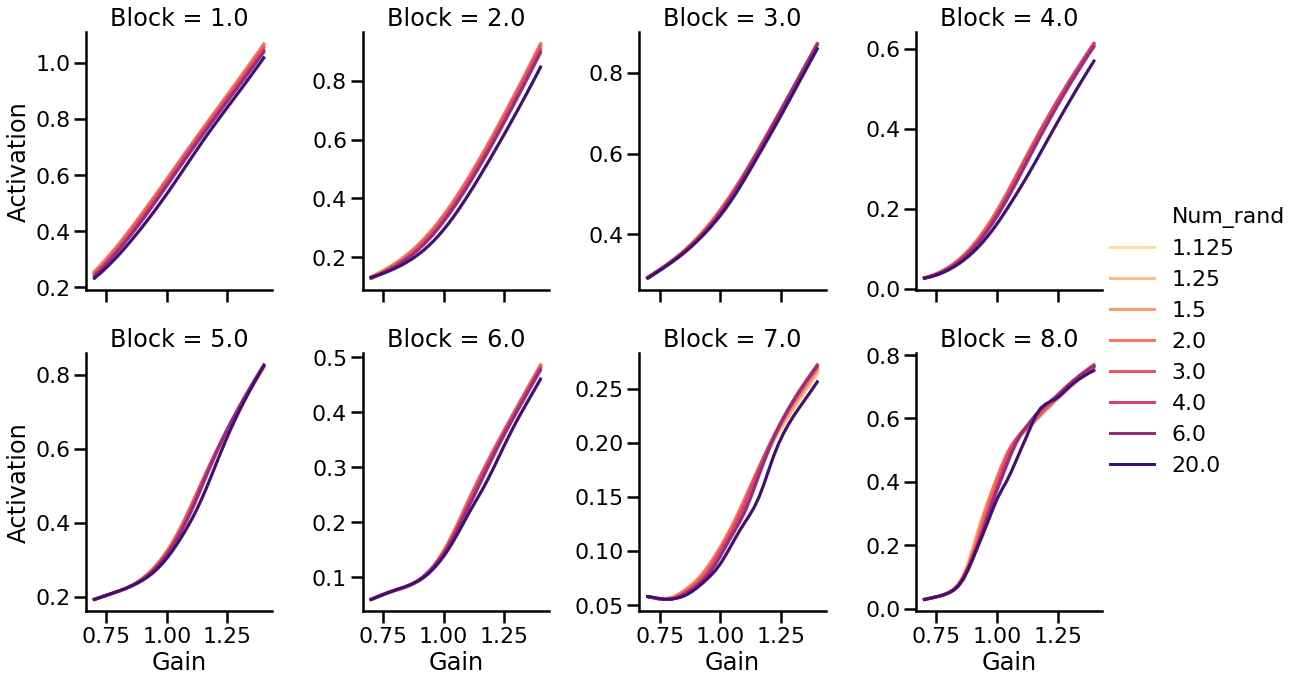

In [5]:
# FigureS2A
ax = sns.relplot(data=df, x='Gain', y='Activation', hue='Num_rand', col='Block', col_wrap=4, palette=colors_select,
                 kind='line', err_kws={'alpha': 0.4},  height=5, aspect=0.8, facet_kws={'sharey':False})
plt.show()

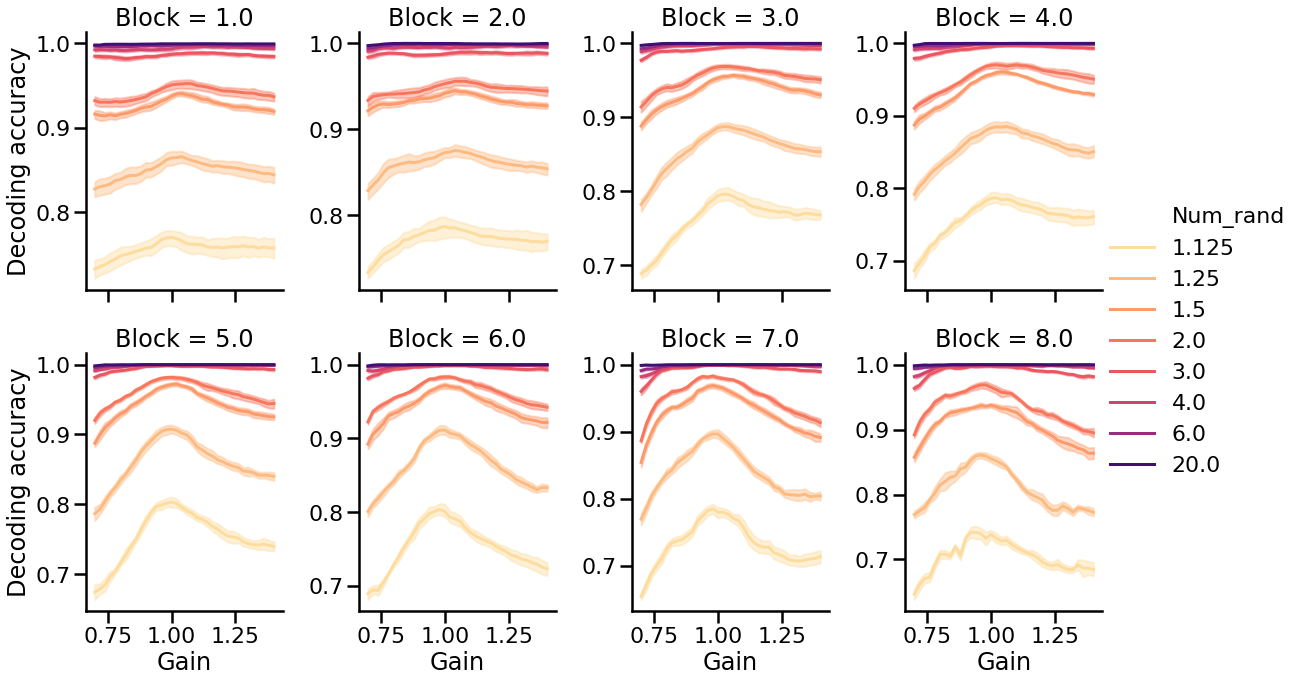

In [6]:
# FigureS2B
ax = sns.relplot(data=df, x='Gain', y='Decoding accuracy', hue='Num_rand', col='Block', col_wrap=4, palette=colors_select,
                 kind='line', err_kws={'alpha': 0.4},  height=5, aspect=0.8, facet_kws={'sharey': False})
plt.show()

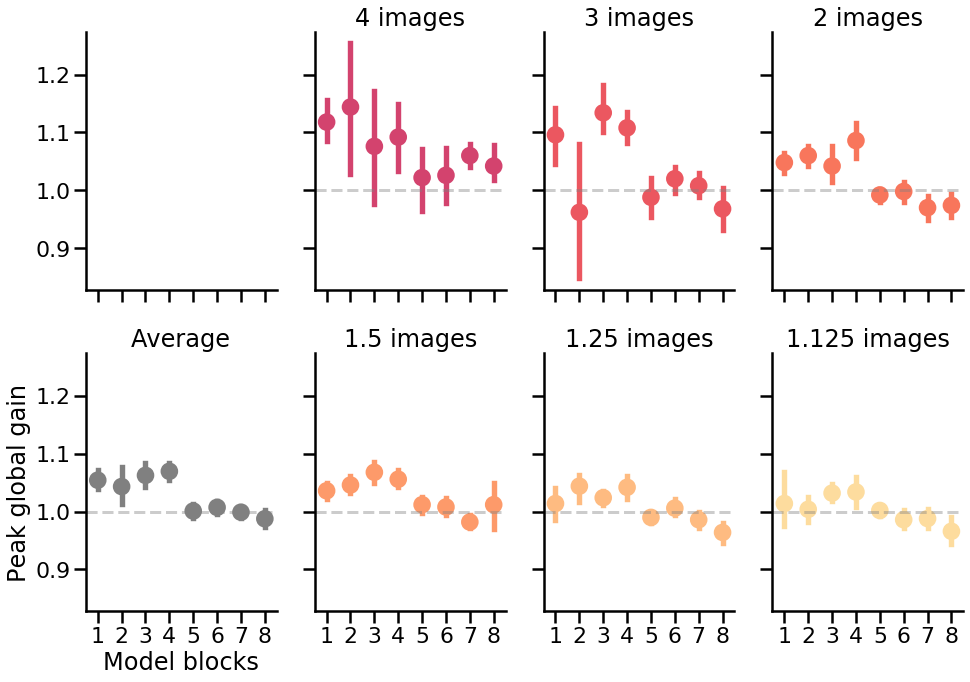

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(14, 10), sharex=True, sharey=True)
ax = ax.flatten()
colors_scatter = [colors[c] for c in color_idx[:-1]]
order = list(reversed(num_rands))
ax_ids = [1,2,3,5,6,7]

for n, num_rand in enumerate(reversed(num_rands[:-1])):
    tag = 'random' + str(num_rand)
    max_gain = []
    cond_gain = []
    for p, l in enumerate(layers_i):
        for i in range(tracker_info['training']):
            max_gain.append(tracker_info['gains'][int(np.median(np.where(tracker_info[tag]['training_' + str(i)][l] == tracker_info[tag]['training_' + str(i)][l].max())[0]))])
            cond_gain.append(p+1)

    sns.pointplot(x=cond_gain, y=max_gain, legend=False, color=colors_scatter[-(n+1)],
                  dodge=True, join=False, ax=ax[ax_ids[n]])

    ax[ax_ids[n]].set_title(str(num_rand) + ' images')
    ax[ax_ids[n]].axhline(1, c='gray', alpha=0.4, ls='--')
    sns.despine()
ax[4].set_ylabel('Peak global gain')
ax[4].set_xlabel('Model blocks')

#Plot the average per block
max_gain_all = []
cond_gain_all = []
for p, l in enumerate(layers_i):
    for n, num_rand in enumerate(reversed(num_rands[:-1])):
        tag = 'random' + str(num_rand)
        for i in range(tracker_info['training']):
            max_gain_all.append(tracker_info['gains'][int(np.median(np.where(tracker_info[tag]['training_' + str(i)][l] == tracker_info[tag]['training_' + str(i)][l].max())[0]))])
            cond_gain_all.append(p+1)

sns.pointplot(x=cond_gain_all, y=max_gain_all, legend=False, color=(0.5, 0.5, 0.5),
                  dodge=True, join=False, ax=ax[4])

ax[4].set_title('Average')
ax[4].axhline(1, c='gray', alpha=0.4, ls='--')

plt.tight_layout()
plt.show()

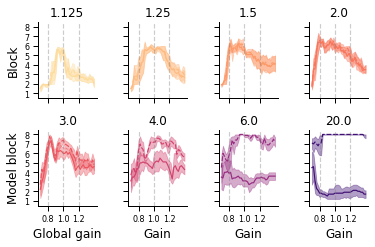

In [7]:
cm = 1 / 2.54
sns.set_context('paper', rc={'font.size': 10,  'xtick.labelsize': 8, 'ytick.labelsize': 8,
                                 'figure.titleweight': 'bold', 'axes.labelsize': 12, 'axes.titlesize': 12})


# Figure S4A
mostInformation = []
for n, num_rand in enumerate(num_rands):
    for i, g in enumerate(tracker['gains']):
        for t in range(trainings):
            tmp = df[(df['Num_rand'] == num_rand) & (df['Gain'] == g) & (df['Training'] == t)]
            for mode in ['min', 'max']:
                if mode == 'min':
                    mostInformation.append({'Num_rand':num_rand, 'Gain': g, 'Block':tmp.loc[tmp['Decoding accuracy'] ==tmp['Decoding accuracy'].max() , 'Block'].min(),
                                            'Decoding accuracy': tmp['Decoding accuracy'].max(),
                                            'mode': mode})
                elif mode == 'max':
                    mostInformation.append({'Num_rand': num_rand, 'Gain': g, 'Block': tmp.loc[
                        tmp['Decoding accuracy'] == tmp['Decoding accuracy'].max(), 'Block'].max(),
                                            'Decoding accuracy': tmp['Decoding accuracy'].max(),
                                            'mode': mode})
                else:
                    raise ValueError()

mostInformation = pd.DataFrame(mostInformation)

g = sns.relplot(data=mostInformation, x='Gain', y='Block', style='mode', hue='Num_rand', col='Num_rand',col_wrap=4, palette=colors_select,
                 kind='line', err_kws={'alpha': 0.4},  height=4.5*cm, aspect=0.75, legend=None)#, facet_kws={'sharex': False})


g.set_titles('{col_name}')

#ax.refline(x=1, linestyle=":")
g.axes[0].set_ylim([0.5,8.5])
g.axes[0].set_yticks([1,2,3,4,5,6,7,8])
g.axes[0].set_xticks([0.8, 1, 1.2])
g.axes[4].set_xlabel('Global gain')
g.axes[4].set_ylabel('Model block')
for ax in g.axes:

    ax.axvline(1, color= 'grey', ls = '--', alpha=0.4)
    ax.axvline(0.8, color='grey', ls='--', alpha=0.4)
    ax.axvline(1.2, color='grey', ls='--', alpha=0.4)

plt.tight_layout()
plt.show()


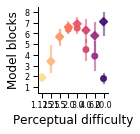

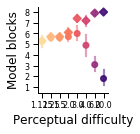

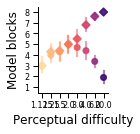

In [8]:
# Figure 5E
for g in [0.8, 1, 1.2]:
    ax = sns.catplot(data=mostInformation[(mostInformation['Gain'] == g) & (mostInformation['mode']=='max')],
                     x='Num_rand', y='Block', palette=colors_select,
                       kind='point',height=5*cm, aspect=0.95, legend=None, markers='D')


    ax.map(sns.pointplot, data=mostInformation[(mostInformation['Gain'] == g) & (mostInformation['mode']=='min')],
                     x='Num_rand', y='Block', palette=colors_select,
                     kind='point',  legend=None)

    plt.setp(ax.ax.collections, alpha=.9)
    plt.setp(ax.ax.lines, alpha=.5)
    ax.ax.set_ylim([0.5,8.5])

    ax.ax.set_yticks([1,2,3,4,5,6,7,8])

    ax.ax.set_ylabel('Model blocks')
    ax.ax.set_xlabel('Perceptual difficulty')

    plt.tight_layout()
    plt.show()